In [ ]:
# Copyright 2024 The AI Edge Torch Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

This Colab demonstrates how to convert a PyTorch [MobileViT](https://huggingface.co/docs/transformers/en/model_doc/mobilevit#overview) model to a TensorFlow Lite Quantized DRQ model and run it, using the ai_edge_torch library.

# Prerequisites

First install all dependencies.

In [ ]:
!pip install -r https://raw.githubusercontent.com/google-ai-edge/ai-edge-torch/main/requirements.txt
!pip install ai-edge-torch
!pip install transformers pillow requests matplotlib

Then download and read the test image.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   279  100   279    0     0   1024      0 --:--:-- --:--:-- --:--:--  1025
100  144k  100  144k    0     0   268k      0 --:--:-- --:--:-- --:--:-- 7365k


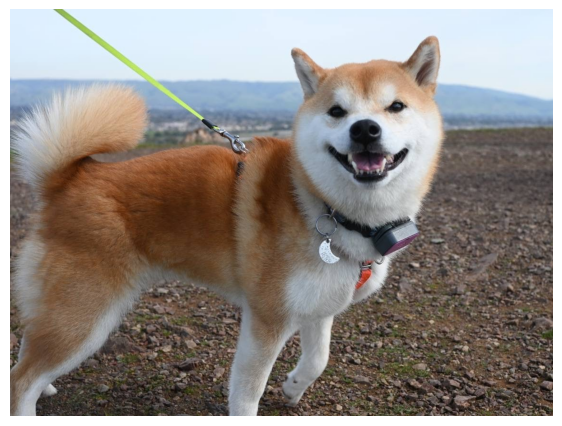

In [2]:
!curl -H 'Accept: application/vnd.github.v3.raw'  -O   -L https://api.github.com/repos/google-ai-edge/ai-edge-torch/contents/test/image_classification/test_data/astrid_happy_hike.jpg;

from matplotlib import pyplot as plt
from PIL import Image

image_path = 'astrid_happy_hike.jpg'
image = Image.open(image_path)
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(image)

# PyTorch Model Wrapper
Before converting the PyTorch model to ai-edge-torch model, a wrapper must be added to conform to the model input format expected by ai-edge-torch.

ai-edge-torch only accepts a tuple-of-tensors as model input and produces a tensor or tuple-of-tensor as model output.

In [3]:
import torch
from torch import nn

class MobileViTForImageClassificationWrapper(nn.Module):

  def __init__(self, model):
    super().__init__()
    self.m = model

  def forward(self, img):
    return self.m(pixel_values=img).logits

# PyTorch Model and Validation Utilities

Prepare PyTorch model and corresponding image processor to process the input image to a format required by MobileViT model.

In [ ]:
from transformers import MobileViTImageProcessor, MobileViTForImageClassification


hf_model_path = 'apple/mobilevit-small'
image_processor = MobileViTImageProcessor.from_pretrained(hf_model_path)
hf_pt_model = MobileViTForImageClassification.from_pretrained(hf_model_path)

# Utility function to get %probablilities and corresponding class labels
# defined in MobileViTForImageClassification
# This utility applies softmax to convert logits to probabilities and shows
# top-5 of predicted classes.
def get_classification_probablities(logits):
  probs, indices = torch.nn.functional.softmax(logits, dim=-1).flatten().topk(k=5)
  for i in range(len(indices)):
    class_label = hf_pt_model.config.id2label[indices[i].item()]
    prob = probs[i].item()
    print(f'{(prob * 100):4.1f}%  {class_label}')

wrapped_pt_model = MobileViTForImageClassificationWrapper(hf_pt_model).eval()

In [5]:
processed_inputs = image_processor(
    images=image,
    return_tensors='pt',
)

input_tensor = processed_inputs['pixel_values']

Run the model on prepared inputs to get classification over 1000 ImageNet classes.

In [6]:
wrapped_pt_model_outputs = wrapped_pt_model(input_tensor)
predicted_class_idx = wrapped_pt_model_outputs.argmax(-1).item()
print(f'Predicted class: {hf_pt_model.config.id2label[predicted_class_idx]}')

Predicted class: Pembroke, Pembroke Welsh corgi


Use the get_classification_probablities utility.

In [7]:
get_classification_probablities(wrapped_pt_model_outputs)

68.0%  Pembroke, Pembroke Welsh corgi
 8.5%  Eskimo dog, husky
 6.6%  Siberian husky
 1.6%  Cardigan, Cardigan Welsh corgi
 1.2%  dingo, warrigal, warragal, Canis dingo


# Convert to `ai-edge-torch` model and run

Provide sample arguments -- result TFLite model will expect input of this size -- and convert the model.

In [ ]:
import ai_edge_torch
import tensorflow as tf

sample_args = (torch.rand((1, 3, 256, 256)),)

edge_model = ai_edge_torch.convert(wrapped_pt_model, sample_args)

In [9]:
edge_model_output = edge_model(input_tensor)

get_classification_probablities(torch.tensor(edge_model_output))

68.0%  Pembroke, Pembroke Welsh corgi
 8.5%  Eskimo dog, husky
 6.6%  Siberian husky
 1.6%  Cardigan, Cardigan Welsh corgi
 1.2%  dingo, warrigal, warragal, Canis dingo


# Save and download the ai-edge-torch Model

In [ ]:
from google.colab import files


ai_edge_torch_file = 'hf_mobile_vit.tflite'
edge_model.export(ai_edge_torch_file)

files.download(ai_edge_torch_file)

# Post Training Quantization with TfLite

In [11]:
import ai_edge_torch
import tensorflow as tf

sample_args = (torch.rand((1, 3, 256, 256)),)

tfl_converter_flags = {'optimizations': [tf.lite.Optimize.DEFAULT]}

# Pass quantization flags to the TfLite Converter using the _ai_edge_converter_flags parameter.
# More details on post-training quantization are at: https://www.tensorflow.org/lite/performance/post_training_quantization
tfl_drq_model = ai_edge_torch.convert(
    wrapped_pt_model, sample_args, _ai_edge_converter_flags=tfl_converter_flags
)

In [12]:
tfl_drq_output = tfl_drq_model(input_tensor)

get_classification_probablities(torch.tensor(tfl_drq_output))

91.0%  Pembroke, Pembroke Welsh corgi
 2.8%  Cardigan, Cardigan Welsh corgi
 0.2%  Chihuahua
 0.2%  dingo, warrigal, warragal, Canis dingo
 0.2%  Siberian husky


# Save and download the quantized ai-edge-torch Model

In [ ]:
tfl_drq_file = 'hf_mobile_vit_drq.tflite'
tfl_drq_model.export(tfl_drq_file)

files.download(tfl_drq_file)

# Post Training and Dynamic-Range Quantization with PT2E

In [ ]:
from ai_edge_torch.quantize.pt2e_quantizer import get_symmetric_quantization_config
from ai_edge_torch.quantize.pt2e_quantizer import PT2EQuantizer
from ai_edge_torch.quantize.quant_config import QuantConfig

from torch.ao.quantization.quantize_pt2e import prepare_pt2e, convert_pt2e
from torch._export import capture_pre_autograd_graph

# PT2E is a framework-level quantization feature available in PyTorch 2.0.
# For more details see-
# https://pytorch.org/tutorials/prototype/quantization_in_pytorch_2_0_export_tutorial.html

# PT2EQuantizer is ai-edge-torch backend specific and is configured to quantize models
# to leverage the quantized operators/kernels offered by the TFLite Runtime.
pt2e_quantizer = PT2EQuantizer().set_global(
    get_symmetric_quantization_config(is_per_channel=True, is_dynamic=True)
)

# Following are the required steps recommended in the pt2e quantization workflow.
autograd_torch_model = capture_pre_autograd_graph(wrapped_pt_model, sample_args)
# 1. Prepare for quantization
pt2e_torch_model = prepare_pt2e(autograd_torch_model, pt2e_quantizer)
# 2. Run the prepared model with sample input data to ensure that internal
# observers are populated with correct values
pt2e_torch_model(*sample_args)
# 3. Finally, convert(quantize) the prepared model
pt2e_torch_model = convert_pt2e(pt2e_torch_model, fold_quantize=False)

pt2e_drq_model = ai_edge_torch.convert(pt2e_torch_model, sample_args, quant_config=QuantConfig(pt2e_quantizer=pt2e_quantizer))

In [14]:
pt2e_drq_output = pt2e_drq_model(input_tensor)

get_classification_probablities(torch.tensor(pt2e_drq_output))

26.1%  Pembroke, Pembroke Welsh corgi
13.7%  Eskimo dog, husky
12.1%  Norwegian elkhound, elkhound
 8.9%  Siberian husky
 5.8%  dingo, warrigal, warragal, Canis dingo


# Save and download the PT2E quantized ai-edge-torch Model

In [ ]:
pt2e_drq_file = 'hf_mobile_vit_pt2e_drq.tflite'
pt2e_drq_model.export(pt2e_drq_file)

files.download(pt2e_drq_file)